In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import geopandas as gpd
import folium
import seaborn as sns
from sklearn.cluster import KMeans
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# Main Dataset 

In [2]:
#Import of the dataset
path = 'D:\\Documents\\Python\\Part I\\Datasets\\country_partner_sitcproduct2digit_year.dta'

df = pd.read_stata(path)

In [3]:

df.dtypes

location_id            int32
partner_id             int32
product_id             int32
year                 float64
export_value         float64
import_value         float64
sitc_eci             float64
sitc_coi             float64
location_code         object
partner_code          object
sitc_product_code     object
dtype: object

In [4]:
df.head()

,location_id,partner_id,product_id,year,export_value,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code
0,0,1,102,2018.0,27560.0,0.0,0.800212,0.174964,ABW,AFG,02
1,0,1,102,2019.0,51178.0,0.0,0.935727,-0.282090,ABW,AFG,02
2,7,1,102,2013.0,5530393.0,7302.0,-0.338417,-0.754102,ARE,AFG,02
3,7,1,102,2019.0,3661820.0,0.0,0.321754,0.026674,ARE,AFG,02
4,7,1,102,2021.0,1304571.0,0.0,0.124103,0.087807,ARE,AFG,02


The import_value column contains the total value of imports for a specific product in a specific year (in thousands of US dollars.)

The export_value column contains the total value of imports for a specific product in a specific year (in thousands of US dollars.)

sitc_eci: The sitc_eci column in the data table represents the Economic Complexity Index (ECI) for a given location, partner, and product in a specific year.


sitc_coi : The sitc_coi column contains the comparative advantage index for a given product in a given country.

The SITC_product_code is a code that identifies a specific product in the data table.


The partner_code column contains the partner codes for each row in the data table.

Since we only have the ISO names for each country, we're going to add the real names, so datas will be easier to read

## 1) Left join with countries,names and regions

In [58]:
path = 'D:\\Documents\\Python\\Part I\\Datasets\\country_codes.csv'

country_codes = pd.read_csv(path)

In [4]:
#We only keep those 3 variables, the others aren't that useful for this project
country_codes = country_codes[[ 'alpha-3', 'name', 'region']]

country_codes.head()

,alpha-3,name,region
0,AFG,Afghanistan,Asia
1,ALA,Åland Islands,Europe
2,ALB,Albania,Europe
3,DZA,Algeria,Africa
4,ASM,American Samoa,Oceania


In [5]:
#A left join is performed to get the full name of countries, and their regions
df_merge = pd.merge(df,country_codes, left_on='location_code', right_on='alpha-3', how='left')
df_merge  = df_merge.rename(columns={'name': 'country_name', 'region':'country_region'})
df_merge  = df_merge.drop(['alpha-3'],axis=1)

#Same thing, but for partner countries
df_merge  = pd.merge(df_merge ,country_codes, left_on='partner_code', right_on='alpha-3', how='left')
df_merge = df_merge.rename(columns={'name': 'partner_name', 'region':'partner_region'})
df_merge  = df_merge.drop(['alpha-3'],axis=1)

df_merge.head()

,location_id,partner_id,product_id,year,export_value,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code,country_name,country_region,partner_name,partner_region
0,0,1,102,2018.0,27560.0,0.0,0.800212,0.174964,ABW,AFG,02,Aruba,Americas,Afghanistan,Asia
1,0,1,102,2019.0,51178.0,0.0,0.935727,-0.282090,ABW,AFG,02,Aruba,Americas,Afghanistan,Asia
2,7,1,102,2013.0,5530393.0,7302.0,-0.338417,-0.754102,ARE,AFG,02,United Arab Emirates,Asia,Afghanistan,Asia
3,7,1,102,2019.0,3661820.0,0.0,0.321754,0.026674,ARE,AFG,02,United Arab Emirates,Asia,Afghanistan,Asia
4,7,1,102,2021.0,1304571.0,0.0,0.124103,0.087807,ARE,AFG,02,United Arab Emirates,Asia,Afghanistan,Asia


## 1) Left join with name of products

In [59]:
# 1) Left join with name of products
path = 'D:\\Documents\\Python\\Part I\\Datasets\\SITC_Products.xlsx'

sitc_products = pd.read_excel(path)

In [14]:
sitc_products.dtypes

Code            object
Code_1          object
Product_name    object
dtype: object

In [7]:
#A left join is performed to get the n
df_full = pd.merge(df_merge,sitc_products, left_on='sitc_product_code', right_on='Code', how='left')


df_full.head()

,location_id,partner_id,product_id,year,export_value,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code,country_name,country_region,partner_name,partner_region,Code,Code_1,Product_name
0,0,1,102,2018.0,27560.0,0.0,0.800212,0.174964,ABW,AFG,02,Aruba,Americas,Afghanistan,Asia,02,0,Dairy products and eggs
1,0,1,102,2019.0,51178.0,0.0,0.935727,-0.282090,ABW,AFG,02,Aruba,Americas,Afghanistan,Asia,02,0,Dairy products and eggs
2,7,1,102,2013.0,5530393.0,7302.0,-0.338417,-0.754102,ARE,AFG,02,United Arab Emirates,Asia,Afghanistan,Asia,02,0,Dairy products and eggs
3,7,1,102,2019.0,3661820.0,0.0,0.321754,0.026674,ARE,AFG,02,United Arab Emirates,Asia,Afghanistan,Asia,02,0,Dairy products and eggs
4,7,1,102,2021.0,1304571.0,0.0,0.124103,0.087807,ARE,AFG,02,United Arab Emirates,Asia,Afghanistan,Asia,02,0,Dairy products and eggs


# Focus on 2020

## 1) Dataset

In [9]:
#df_2020 is the dataset which contains only datas from 2020
df_2020 = df_full.loc[df_full['year'] == 2020]

In [222]:
df_2020.head()

,location_id,partner_id,product_id,year,export_value,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code,country_name,country_region,partner_name,partner_region,Code,Product_name
6,7,1,102,2020.0,2403419.0,0.0,0.299904,0.312305,ARE,AFG,02,United Arab Emirates,Asia,Afghanistan,Asia,02,Dairy products and eggs
54,15,1,102,2020.0,593178.0,0.0,1.770081,-0.119985,AUT,AFG,02,Austria,Europe,Afghanistan,Asia,02,Dairy products and eggs
66,16,1,102,2020.0,1354829.0,0.0,-1.303499,-1.351571,AZE,AFG,02,Azerbaijan,Asia,Afghanistan,Asia,02,Dairy products and eggs
101,24,1,102,2020.0,34720.0,0.0,0.481264,-0.457299,BHR,AFG,02,Bahrain,Asia,Afghanistan,Asia,02,Dairy products and eggs
103,28,1,102,2020.0,600128.0,0.0,0.818073,1.094653,BLR,AFG,02,Belarus,Europe,Afghanistan,Asia,02,Dairy products and eggs


## 2) About trade balance 

In [71]:
#Group by countries, we use the sum to know the total export and import value for 2020
country_2020 = df_2020.groupby('country_name').sum()

#The relevant variables for this study are selected
country_2020 = country_2020[['export_value', 'import_value']]

#Trade balance is added, so we can know the trade deficits and excesses 
country_2020['trade_balance'] = country_2020['export_value'] - country_2020['import_value']
country_2020.head()

,export_value,import_value,trade_balance
country_name,,,
Afghanistan,1.815688e+09,6.995495e+09,-5.179807e+09
Albania,2.504691e+09,5.360462e+09,-2.855771e+09
Algeria,2.198670e+10,3.446244e+10,-1.247574e+10
American Samoa,1.920426e+07,1.331240e+08,-1.139197e+08
Andorra,9.964764e+07,1.481098e+09,-1.381451e+09


In [72]:
#Top 10 of countries with biggest trade excesses
country_2020.sort_values(by='trade_balance', ascending=False)[0:10]

,export_value,import_value,trade_balance
country_name,,,
China,2.619172e+12,2.069567e+12,5.496054e+11
Germany,1.385852e+12,1.173166e+12,2.126851e+11
"Taiwan, Province of China",4.276895e+11,2.874280e+11,1.402614e+11
Russian Federation,3.385707e+11,2.316633e+11,1.069074e+11
Ireland,2.004839e+11,9.943959e+10,1.010443e+11
United Arab Emirates,3.352959e+11,2.469602e+11,8.833571e+10
Malaysia,2.833302e+11,1.953060e+11,8.802424e+10
"Korea, Republic of",5.420605e+11,4.674973e+11,7.456324e+10
Italy,4.988029e+11,4.264747e+11,7.232820e+10


In [73]:
#Top 10 of countries with biggest trade deficits
country_2020.sort_values(by='trade_balance', ascending=False)[-10:]

,export_value,import_value,trade_balance
country_name,,,
Pakistan,2.328636e+10,4.676255e+10,-2.347619e+10
Belgium,3.092986e+11,3.346753e+11,-2.537671e+10
Hong Kong,5.515152e+11,5.805247e+11,-2.900949e+10
Philippines,7.838738e+10,1.086993e+11,-3.031189e+10
Egypt,2.945080e+10,6.764472e+10,-3.819392e+10
Turkey,1.724836e+11,2.195131e+11,-4.702945e+10
India,2.790430e+11,3.679799e+11,-8.893682e+10
France,4.885617e+11,5.827742e+11,-9.421250e+10
United Kingdom of Great Britain and Northern Ireland,3.956910e+11,6.341738e+11,-2.384827e+11


The results are quite surprising. Indeed, 2020 corresponds to the beginning of the Corona crisis, and China was probably the most impacted country, since it's from where it started. Though, China is still the country with the biggest trade excesses. On the other hand, it seems that the crisis impacted strong economic countries, such as France, UK and USA 

Since the imported goods are largely superieur to exported good, then a trade deficit country mean it's very dependent on others countries. The main problem with this, is that the economy of a trade deficit country is very volatile: if the economy of one of their partners collapse, then it will be the same of theirs. Moreover, on a political level, it means that your position should be tied with your partners, so you can still supply your country properly. If not, your partner could rise their prices in the best case, or even stop to trade with you in the worst case, which could have very negative consequences for your economy.

## 3) Connected countries

In [11]:
#the most connected countries in terms of international trend are the countries which are the most involved in the dataset
df_2020['country_name'].value_counts()[0:10]

United States of America                                11946
China                                                   11562
Germany                                                 11213
Netherlands                                             10851
France                                                  10819
United Kingdom of Great Britain and Northern Ireland    10777
Italy                                                   10450
Spain                                                   10208
India                                                   10037
Belgium                                                  9803
Name: country_name, dtype: int64

In [12]:
#Same thing, with the least involved countries
df_2020['country_name'].value_counts()[-10:]

Antarctica                                      150
Holy See                                        144
British Indian Ocean Territory                  112
Niue                                            107
Cocos (Keeling) Islands                         101
Pitcairn                                         81
Western Sahara                                   27
Heard Island and McDonald Islands                10
Bouvet Island                                    10
South Georgia and the South Sandwich Islands      6
Name: country_name, dtype: int64

In [32]:
df_2020.head()

,location_id,partner_id,product_id,year,export_value,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code,country_name,country_region,partner_name,partner_region,Code,Product_name
6,7,1,102,2020.0,2403419.0,0.0,0.299904,0.312305,ARE,AFG,02,United Arab Emirates,Asia,Afghanistan,Asia,02,Dairy products and eggs
54,15,1,102,2020.0,593178.0,0.0,1.770081,-0.119985,AUT,AFG,02,Austria,Europe,Afghanistan,Asia,02,Dairy products and eggs
66,16,1,102,2020.0,1354829.0,0.0,-1.303499,-1.351571,AZE,AFG,02,Azerbaijan,Asia,Afghanistan,Asia,02,Dairy products and eggs
101,24,1,102,2020.0,34720.0,0.0,0.481264,-0.457299,BHR,AFG,02,Bahrain,Asia,Afghanistan,Asia,02,Dairy products and eggs
103,28,1,102,2020.0,600128.0,0.0,0.818073,1.094653,BLR,AFG,02,Belarus,Europe,Afghanistan,Asia,02,Dairy products and eggs


## 4) USA partners

### a) Imports

In [10]:
#All imports of USA
df_USA_imp = df_2020.loc[df_2020['location_code'] == 'USA']


In [275]:
df_USA_imp['partner_code'].value_counts()

CAN    68
MEX    68
CHL    67
ZAF    67
BRA    67
       ..
TUV     8
HMD     7
SPM     6
ESH     2
ANS     1
Name: partner_code, Length: 223, dtype: int64

In [14]:
USA_imports = df_USA_imp.groupby('partner_code').size().reset_index(name='Number of imports')
USA_imports.tail()

,partner_code,Number of imports
218,WSM,46
219,YEM,49
220,ZAF,67
221,ZMB,61
222,ZWE,55


In [276]:
USA_imports.sort_values(by='Number of imports', ascending=True)

,partner_code,Number of imports
6,ANS,1
63,ESH,2
180,SPM,6
88,HMD,7
204,TUV,8
...,...,...
70,FRA,67
161,POL,67
101,ITA,67
128,MEX,68


In [11]:
path = 'D:\\Documents\\Python\\Part I\\Datasets\\country-coord.csv'

country_coord = pd.read_csv(path)

In [12]:
country_coord = country_coord.drop(['Alpha-2 code','Numeric code'], axis=1)

country_coord.head()

,Country,Alpha-3 code,Latitude (average),Longitude (average)
0,Afghanistan,AFG,33.0000,65.0
1,Albania,ALB,41.0000,20.0
2,Algeria,DZA,28.0000,3.0
3,American Samoa,ASM,-14.3333,-170.0
4,Andorra,AND,42.5000,1.6


In [15]:
#Left join to get the Latitude/Longitude
USA_imports_merge = pd.merge(USA_imports,country_coord, left_on='partner_code', right_on='Alpha-3 code', how='left')
USA_imports_merge = USA_imports_merge.rename(columns={'Latitude (average)': 'Latitude', 'Longitude (average)':'Longitude'})
USA_imports_merge  = USA_imports_merge.drop(['Alpha-3 code'],axis=1)
USA_imports_merge.head()

,partner_code,Number of imports,Country,Latitude,Longitude
0,ABW,66,Aruba,12.50,-69.9667
1,AFG,57,Afghanistan,33.00,65.0000
2,AGO,59,Angola,-12.50,18.5000
3,AIA,56,Anguilla,18.25,-63.1667
4,ALB,57,Albania,41.00,20.0000


In [84]:
USA_imports_merge.loc[USA_imports_merge['Latitude'].isna() == True]

,partner_code,Count,Country,Latitude,Longitude
6,ANS,1,NaN,NaN,NaN
49,CUW,61,NaN,NaN,NaN
189,SXM,64,NaN,NaN,NaN


We have NaN value for Curaçao, St Marin and another country. I delete them because it'll take too much time to find their coordinates and I think it's not the point of this exercice

In [16]:
USA_imports_merge = USA_imports_merge.dropna()

In [17]:
usa_map_imp = folium.Map(location=[37.0902, -95.7129], zoom_start=3)

for index, row in USA_imports_merge.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=row['Number of imports']/ 10,  # Adjust the radius based on your preference
        color='blue',
        fill=False,
        fill_color='blue',
        fill_opacity=0.7,
        popup=f"{row['Country']} - Number of imports: {row['Number of imports']:,}"
    ).add_to(usa_map_imp)

In [18]:
usa_map_imp

## Clustering

In [19]:
df_clust = df_2020

In [20]:
df_clust.head()

,location_id,partner_id,product_id,year,export_value,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code,country_name,country_region,partner_name,partner_region,Code,Code_1,Product_name
6,7,1,102,2020.0,2403419.0,0.0,0.299904,0.312305,ARE,AFG,02,United Arab Emirates,Asia,Afghanistan,Asia,02,0,Dairy products and eggs
54,15,1,102,2020.0,593178.0,0.0,1.770081,-0.119985,AUT,AFG,02,Austria,Europe,Afghanistan,Asia,02,0,Dairy products and eggs
66,16,1,102,2020.0,1354829.0,0.0,-1.303499,-1.351571,AZE,AFG,02,Azerbaijan,Asia,Afghanistan,Asia,02,0,Dairy products and eggs
101,24,1,102,2020.0,34720.0,0.0,0.481264,-0.457299,BHR,AFG,02,Bahrain,Asia,Afghanistan,Asia,02,0,Dairy products and eggs
103,28,1,102,2020.0,600128.0,0.0,0.818073,1.094653,BLR,AFG,02,Belarus,Europe,Afghanistan,Asia,02,0,Dairy products and eggs


In [225]:
#df_clust['Code'] = df_clust['Code'].str[0]

<ipython-input-225-b453c72726e3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clust['Code'] = df_clust['Code'].str[0]


In [226]:
df_clust.head()

,location_id,partner_id,product_id,year,export_value,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code,country_name,country_region,partner_name,partner_region,Code,Product_name
6,7,1,102,2020.0,2403419.0,0.0,0.299904,0.312305,ARE,AFG,02,United Arab Emirates,Asia,Afghanistan,Asia,0,Dairy products and eggs
54,15,1,102,2020.0,593178.0,0.0,1.770081,-0.119985,AUT,AFG,02,Austria,Europe,Afghanistan,Asia,0,Dairy products and eggs
66,16,1,102,2020.0,1354829.0,0.0,-1.303499,-1.351571,AZE,AFG,02,Azerbaijan,Asia,Afghanistan,Asia,0,Dairy products and eggs
101,24,1,102,2020.0,34720.0,0.0,0.481264,-0.457299,BHR,AFG,02,Bahrain,Asia,Afghanistan,Asia,0,Dairy products and eggs
103,28,1,102,2020.0,600128.0,0.0,0.818073,1.094653,BLR,AFG,02,Belarus,Europe,Afghanistan,Asia,0,Dairy products and eggs


In [21]:
df_cluster_cat = df_clust.groupby(['location_code','country_name', 'Code_1']).sum().reset_index()

In [22]:
df_cluster_cat.head()

,location_code,country_name,Code_1,location_id,partner_id,product_id,year,export_value,import_value,sitc_eci,sitc_coi
0,ABW,Aruba,0,0,22411,21318,410060.0,1120664.0,198918678.0,174.099966,-67.033625
1,ABW,Aruba,1,0,6740,6399,117160.0,24208403.0,73126431.0,49.742847,-19.152464
2,ABW,Aruba,2,0,7402,7397,127260.0,7559818.0,7086945.0,54.031024,-20.803539
3,ABW,Aruba,3,0,2997,3050,50500.0,86813504.0,75439234.0,21.440882,-8.255372
4,ABW,Aruba,4,0,2321,2268,36360.0,284755.0,5157943.0,15.437435,-5.943868


In [23]:
#The balance corresponds to exports - imports
df_cluster_cat['Balance'] = df_cluster_cat['export_value'] - df_cluster_cat['import_value']

To have 1 row per country, we need to pivot the table. To do so, we'll pivot using our PC column, so we'll get a new table with a country and its balance for every category.

In [25]:
df_cluster_piv = df_cluster_cat.pivot(index='location_code', columns='Code_1', values='Balance').reset_index()
df_cluster_piv.head()

Code_1,location_code,0,1,2,3,4,5,6,7,8,9
0,ABW,-1.977980e+08,-48918028.0,472873.0,1.137427e+07,-4873188.0,-110047973.0,-1.142675e+08,-24693311.0,-120224186.0,10261055.0
1,AFG,-8.479504e+08,-538642262.0,208671369.0,-4.096615e+08,-266260012.0,-516503667.0,-1.070806e+09,-180915572.0,-393494653.0,-114959894.0
2,AGO,-1.353971e+09,-58666032.0,566799742.0,2.082579e+10,-258985090.0,-899358744.0,-3.602600e+08,-569288246.0,-717025357.0,-48383078.0
3,AIA,-7.836866e+07,-5625061.0,-1251787.0,-1.427098e+07,-198303.0,19040317.0,-1.209724e+07,-2690283.0,-3154278.0,-5797294.0
4,ALB,-4.471333e+08,-117585849.0,57231547.0,-2.358974e+08,-34098592.0,-549925389.0,-6.853842e+08,-147411840.0,188285180.0,-94451557.0


In [232]:
df_cluster_piv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   location_code  234 non-null    object 
 1   0              232 non-null    float64
 2   1              230 non-null    float64
 3   2              232 non-null    float64
 4   3              231 non-null    float64
 5   4              226 non-null    float64
 6   5              233 non-null    float64
 7   6              234 non-null    float64
 8   7              234 non-null    float64
 9   8              232 non-null    float64
 10  9              232 non-null    float64
dtypes: float64(10), object(1)
memory usage: 20.2+ KB


In [234]:
#We start with the NaN values for the 4th category since it's the one which has the most
df_cluster_piv.loc[df_cluster_piv['4'].isna() == True]

Code,location_code,0,1,2,3,4,5,6,7,8,9
10,ATA,-525110.0,-113162.0,-100233.0,-7674524.0,NaN,-46234.0,-1207683.0,-8663088.0,-81689.0,-453798.0
35,BVT,NaN,NaN,NaN,NaN,NaN,-42405.0,-94326.0,-65271.0,NaN,NaN
54,CXR,-940112.0,-727568.0,644660.0,-6442323.0,NaN,9626954.0,-1705406.0,-845307.0,-817943.0,-5509730.0
67,ESH,-94241.0,NaN,6895165.0,-7039168.0,NaN,105240.0,-28148.0,-98853.0,-724556.0,-42898.0
93,HMD,NaN,NaN,-25837.0,NaN,NaN,NaN,-78876.0,-45824.0,173132.0,-8014.0
163,PCN,1820052.0,-26416.0,29751.0,-570978.0,NaN,-160177.0,-254843.0,93196.0,-88320.0,-246498.0
182,SGS,54003.0,NaN,NaN,NaN,NaN,-38798.0,-120109.0,-105183.0,NaN,NaN
218,UMI,2011123.0,-544396.0,-1749918.0,-2830535.0,NaN,-770760485.0,-823561.0,578240.0,879367.0,-185777.0


It seems that countries who has a missing value for the 4th category have multiples missing values (except for Antartica). So I think it would be better to exclude them from the clustering, otherwise they could be outliers and be in the same cluster just because of their missing values. Since Antartica is also one of the less connected countries in term of international trade, I can't assume a missing value on a category would mean it's equivalent to balance. So I make the choice to also exclude it.

In [26]:

df_cluster_piv= df_cluster_piv.dropna()

In [27]:
#To avoid some problems that could happen later, we reset the index

df_cluster_piv = df_cluster_piv.reset_index(drop=True)

Okay, now we have our datas, but before to do a cluster, it will be more careful to normalize them

In [28]:
# Extract numeric columns (excluding countries)
numeric_columns = df_cluster_piv.select_dtypes(include='number').columns

scaler = MinMaxScaler()

# Fit and transform the numeric columns
df_cluster_piv_normalized_numeric = pd.DataFrame(scaler.fit_transform(df_cluster_piv[numeric_columns]), columns=numeric_columns)

# Combine the normalized numeric columns with countriess (set as index)
df_cluster_piv_normalized = pd.concat([df_cluster_piv_normalized_numeric, df_cluster_piv['location_code']], axis = 1).set_index('location_code')


In [238]:
df_cluster_piv_normalized.head()

,0,1,2,3,4,5,6,7,8,9
location_code,,,,,,,,,,
ABW,0.504444,0.618528,0.727283,0.589632,0.313615,0.359235,0.346468,0.367709,0.369706,0.300786
AFG,0.497046,0.603028,0.727871,0.588455,0.305518,0.356725,0.344159,0.366102,0.369308,0.296624
AGO,0.491288,0.618219,0.728883,0.647803,0.305743,0.354361,0.345874,0.362108,0.368837,0.298837
AIA,0.505803,0.619898,0.727278,0.589560,0.313760,0.360032,0.346715,0.367935,0.369877,0.300253
ALB,0.501607,0.616354,0.727443,0.588941,0.312710,0.356519,0.345089,0.366447,0.370155,0.297306


We're now ready to perform a clustering. Since all our columns are quantitative variables, we can use an ascending hierarchical clustering. This method is useful in our case because we still don't know how many clusters we want. So we'll let the algorithm running, while keeping an eye on interclass distance. When it drops drastically between 2 steps, then it will mean that the number of cluster is relevant

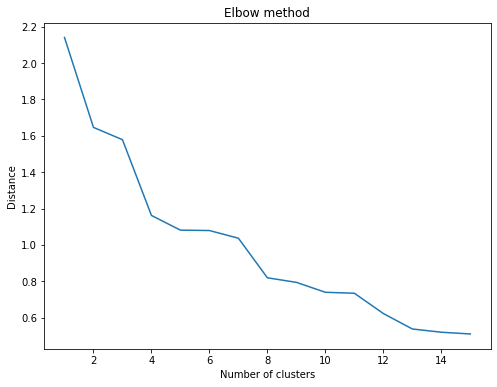

In [239]:
Z = linkage(df_cluster_piv_normalized, method='ward', metric = 'euclidean')
last = Z[-15:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.figure(figsize=(8, 6))
plt.xlabel('Number of clusters')
plt.ylabel('Distance')
plt.title('Elbow method')
plt.plot(idxs, last_rev)

A drop of interclass distance results in an elbow in the plot above. Here, there is an elbow when the number of clusers is 4. So that's the number of cluster we'll use. 

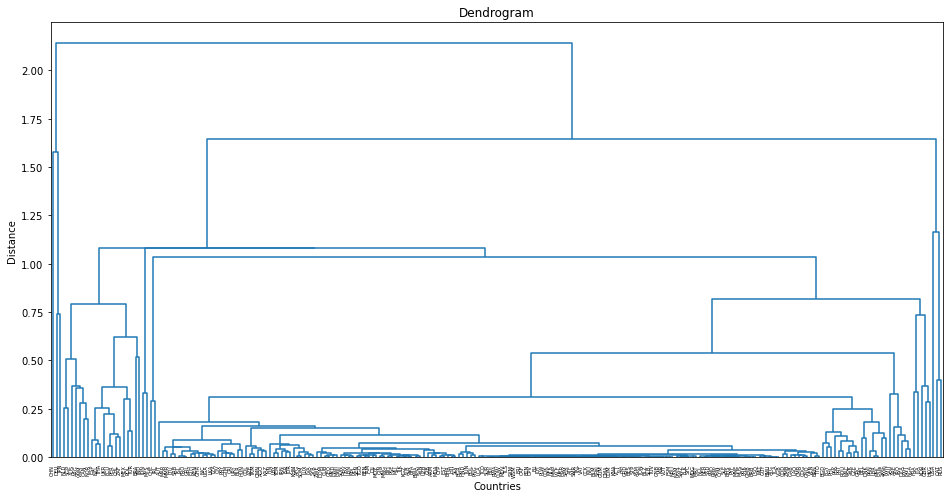

In [29]:
Z = linkage(df_cluster_piv_normalized,method='ward',metric='euclidean')
#affichage du dendrogramme
plt.figure(figsize=(16, 8))
plt.title("Dendrogram")
dendrogram(Z,labels=df_cluster_piv_normalized.index,orientation='top',color_threshold=0)
plt.xlabel('Countries')
plt.ylabel('Distance')
plt.show()

The dengrogram helps us to know the distance between different clusters. We can already notice that there is a cluster which only 1 country, and a single cluster which regroups more than 90% of countries

In [30]:
groupes_cah = fcluster(Z,t=1.5,criterion='distance')

#Create a new column so each country has its group
df_cluster_piv_normalized['Cluster'] = groupes_cah

df_cluster_piv_normalized['Cluster'].value_counts()

3    220
4      3
1      2
2      1
Name: Cluster, dtype: int64

It's quite disappointing because more than 95% of the countries are in the same cluster. But by looking at the dendrogram, it seems that taking more clusters will just create other groups with only 1 country
Let's see what are the means of the balance in every categories of our clusters

In [244]:
# means for every group
round(df_cluster_piv_normalized.groupby('Cluster').mean(),2)*100

,0,1,2,3,4,5,6,7,8,9
Cluster,,,,,,,,,,
1,20.0,51.0,67.0,45.0,28.0,65.0,38.0,99.0,32.0,53.0
2,5.0,50.0,0.0,0.0,0.0,23.0,100.0,69.0,100.0,47.0
3,51.0,62.0,73.0,59.0,32.0,36.0,34.0,36.0,37.0,29.0
4,45.0,39.0,78.0,78.0,30.0,22.0,25.0,18.0,23.0,82.0


In [257]:
df_cluster_piv_normalized.loc[df_cluster_piv_normalized['Cluster'] == 4]

,0,1,2,3,4,5,6,7,8,9,Cluster
location_code,,,,,,,,,,,
QAT,0.478565,0.616546,0.726321,0.670288,0.311125,0.368707,0.341316,0.336270,0.365457,0.875824,4
RUS,0.534987,0.566634,0.756811,1.000000,0.382041,0.302196,0.415690,0.218498,0.339177,1.000000,4
USA,0.329570,0.000000,0.843790,0.673310,0.199932,0.000000,0.000000,0.000000,0.000000,0.597275,4


Now, we can see what can make countries out of the second cluster which contains 95% of countries: <br>
<br>
<br>
-The first cluster is specialist of Chemical products (Germany, Japan)<br>
-The second has excesses in Manufact goods (China) <br>
-The 4th is special because he has great excesses in Mineral fuels and 	Commod. & transacts (Qatar, USA and Russia) <br>
-The 3rd cluster contains all other countries

In [31]:
df_cluster_piv_normalized= df_cluster_piv_normalized.reset_index()

df_cluster_piv_normalized.head()

,location_code,0,1,2,3,4,5,6,7,8,9,Cluster
0,ABW,0.504444,0.618528,0.727283,0.589632,0.313615,0.359235,0.346468,0.367709,0.369706,0.300786,3
1,AFG,0.497046,0.603028,0.727871,0.588455,0.305518,0.356725,0.344159,0.366102,0.369308,0.296624,3
2,AGO,0.491288,0.618219,0.728883,0.647803,0.305743,0.354361,0.345874,0.362108,0.368837,0.298837,3
3,AIA,0.505803,0.619898,0.727278,0.589560,0.313760,0.360032,0.346715,0.367935,0.369877,0.300253,3
4,ALB,0.501607,0.616354,0.727443,0.588941,0.312710,0.356519,0.345089,0.366447,0.370155,0.297306,3


In [32]:
cluster_merge = pd.merge(df_cluster_piv_normalized,country_coord, left_on='location_code', right_on='Alpha-3 code', how='left')
cluster_merge = cluster_merge.rename(columns={'Latitude (average)': 'Latitude', 'Longitude (average)':'Longitude'})
cluster_merge  = cluster_merge[['location_code','Country', 'Latitude', 'Longitude', 'Cluster']]
cluster_merge  = cluster_merge .dropna()
cluster_merge.head()

,location_code,Country,Latitude,Longitude,Cluster
0,ABW,Aruba,12.50,-69.9667,3
1,AFG,Afghanistan,33.00,65.0000,3
2,AGO,Angola,-12.50,18.5000,3
3,AIA,Anguilla,18.25,-63.1667,3
4,ALB,Albania,41.00,20.0000,3


In [33]:
world_map = folium.Map(location=[0, 0], zoom_start=2)

def get_group_color(group):
    if group == 1:
        return 'blue'
    elif group == 2:
        return 'green'
    elif group == 3:
        return 'red'
    else:
        return 'gray'

# Iterate through the DataFrame and add markers with colors based on the 'Group' column
for index, row in cluster_merge.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        color=get_group_color(row['Cluster']),
        fill=True,
        fill_color=get_group_color(row['Cluster']),
        fill_opacity=0.7,
        popup=f"{row['Country']} - Cluster: {row['Cluster']}"
    ).add_to(world_map)

In [34]:
world_map

# Trends

In [54]:
#To observ trends, we group by country and year
df_trend = df_full.groupby(['location_code','country_name','year']).sum().reset_index()

df_trend.head()

,location_code,country_name,year,location_id,partner_id,product_id,export_value,import_value,sitc_eci,sitc_coi
0,ABW,Aruba,1988.0,0,9268,12566,201623.0,35440094.0,129.336194,-36.246725
1,ABW,Aruba,1989.0,0,24775,33366,6811921.0,95758759.0,207.972705,-60.636690
2,ABW,Aruba,1990.0,0,43411,49001,41789553.0,300687171.0,-87.926984,-244.765250
3,ABW,Aruba,1991.0,0,48948,56878,171829347.0,378528850.0,-220.599213,-300.006146
4,ABW,Aruba,1992.0,0,57607,68637,374018856.0,480817964.0,-131.765948,-353.910868


In [55]:
df_trend['Balance'] = df_trend['export_value'] - df_trend['import_value']

#Useful columns are kept
df_trend = df_trend[['location_code', 'country_name','year', 'Balance' ]]

## 1) Balance over time (for France, USA, China, Argentina,Germany and Taiwan)

In [56]:


def plot_countries(countries = []):
#The argument correspond to the countries to plot
    countries_to_plot = countries

# Filter the DataFrame for the selected countries
    df_selected = df_trend[df_trend['country_name'].isin(countries_to_plot)]

# Plotting
    plt.figure(figsize=(12, 8))

    for country in countries_to_plot:
        country_data = df_selected[df_selected['country_name'] == country]
        plt.plot(country_data['year'], country_data['Balance'], label=country)

#Add of titles/labels
    plt.xlabel('Year')
    plt.ylabel('Balance')
    plt.title('Balance over time')
    plt.legend()
    plt.grid(True)
    plt.show()


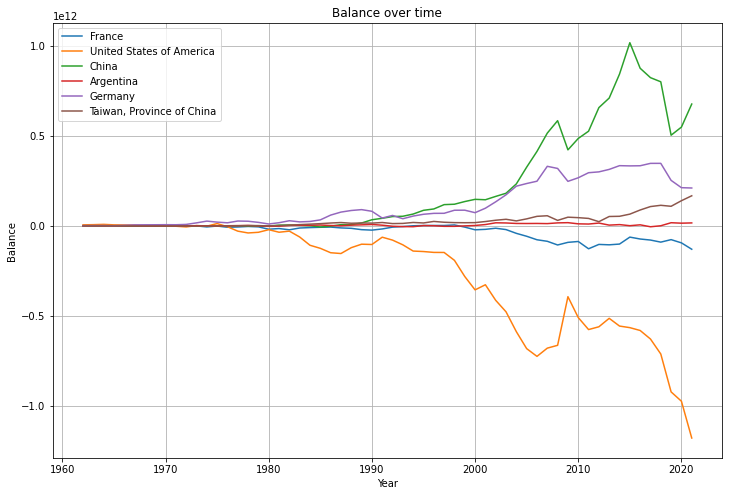

In [57]:
plot_countries(['France','United States of America', 'China', 'Argentina', 'Germany', 'Taiwan, Province of China'])

We can observ that USA and China dynamic are opposed overtime, and it's approximately the same about France and Germany. The result isn't surprising since China has become the most powerful country in term economy, and it seems USA is becoming more dependent of other countries. Contrary to China and USA whose curves tend to fluctuate, France and Germany's tend to stagnate.

Taiwan is starting to have a positive dynamic, and Argentina is the most balanced country here since 1960.


Surprisingly, it seems that the subprime crisis around 2008 affected positively China and the USA

## 2)Clusters on time series 

In [7]:
df_trend.head()

,location_code,year,Balance
0,ABW,1988.0,-35238471.0
1,ABW,1989.0,-88946838.0
2,ABW,1990.0,-258897618.0
3,ABW,1991.0,-206699503.0
4,ABW,1992.0,-106799108.0


In [11]:
df_trend_pivot = df_trend.pivot(index='location_code', columns='year', values='Balance').reset_index()
df_trend_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 61 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   location_code  249 non-null    object 
 1   1962.0         156 non-null    float64
 2   1963.0         154 non-null    float64
 3   1964.0         160 non-null    float64
 4   1965.0         163 non-null    float64
 5   1966.0         162 non-null    float64
 6   1967.0         162 non-null    float64
 7   1968.0         164 non-null    float64
 8   1969.0         166 non-null    float64
 9   1970.0         190 non-null    float64
 10  1971.0         190 non-null    float64
 11  1972.0         193 non-null    float64
 12  1973.0         194 non-null    float64
 13  1974.0         194 non-null    float64
 14  1975.0         193 non-null    float64
 15  1976.0         185 non-null    float64
 16  1977.0         194 non-null    float64
 17  1978.0         194 non-null    float64
 18  1979.0    

We have a lot of countries which didn't have data around 1960, so there is a lot of missing values. To fix this, we'll start at 1970, and assume any missing data is equal to balance (0)

In [12]:
df_trend_70 = df_trend.loc[df_trend['year'] >= 1970]
df_trend_pivot = df_trend_70.pivot(index='location_code', columns='year', values='Balance').reset_index()
df_trend_pivot = df_trend_pivot.fillna(0)
df_trend_pivot.head()

year,location_code,1970.0,1971.0,1972.0,1973.0,1974.0,1975.0,1976.0,1977.0,1978.0,...,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0
0,ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-7.354680e+08,-1.972894e+09,-3.122316e+09,-2.355652e+09,-1.690607e+09,-1.651418e+09,-1.284283e+09,-1.186716e+09,-7.746070e+08,-1.146110e+09
1,AFG,-11152754.0,-15169411.0,-29845854.0,31214602.0,2082300.0,-84841702.0,-65281719.0,-83167217.0,-136241918.0,...,-1.152275e+10,-1.175539e+10,-1.012091e+10,-9.301013e+09,-8.301464e+09,-9.922688e+09,-9.531252e+09,-6.912168e+09,-5.179807e+09,-3.589940e+09
2,AGO,87599104.0,74683789.0,189026969.0,249183360.0,577452378.0,465584030.0,253065385.0,301047482.0,157221583.0,...,4.924332e+10,4.619944e+10,2.723171e+10,1.409283e+10,1.559273e+10,1.911925e+10,3.123020e+10,2.312513e+10,1.437628e+10,2.309355e+10
3,AIA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-4.426135e+07,-1.340045e+08,-7.923736e+07,-6.678665e+07,-5.144689e+07,-8.244131e+07,-1.265890e+08,-1.333269e+08,-1.148935e+08,-2.001999e+08
4,ALB,-14006833.0,-5475952.0,-11033484.0,-9161287.0,-14858803.0,-6916694.0,-5986482.0,5387893.0,-21581011.0,...,-2.533011e+09,-1.922467e+09,-2.188651e+09,-2.139878e+09,-2.372918e+09,-2.550128e+09,-2.803685e+09,-3.062310e+09,-2.855771e+09,-4.257252e+09


Let's make a kmeans model to cluster time series

In [72]:

country_column = 'location_code'
balance_columns = df_trend_pivot.columns.difference([country_column])

# Extract time series data
time_series_data = df_trend_pivot[balance_columns].values

# Rescale the time series data (optional but often recommended)
scaler = StandardScaler()
time_series_data_scaled = scaler.fit_transform(time_series_data)

# Reshape the data for KMeans clustering
X = time_series_data_scaled

# Choose the number of clusters (k)
k = 4

# Perform KMeans clustering
kmeans = KMeans(n_clusters=k, random_state=17)
clusters = kmeans.fit_predict(X)

df_trend_pivot['Cluster'] = clusters

In [73]:
df_trend_pivot['Cluster'].value_counts()

0    242
2      4
1      2
3      1
Name: Cluster, dtype: int64

Again, we have some countries which balances are really different from other, which makes some smalls clusters and another one which regroups almost all countries <br>
Let's see if others clusters are relevant

In [74]:
df_trend_pivot.loc[df_trend_pivot['Cluster'] == 1]

year,location_code,1970.0,1971.0,1972.0,1973.0,1974.0,1975.0,1976.0,1977.0,1978.0,...,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,Cluster
6,ANS,-4.119379e+09,-4.078600e+09,-4.994935e+09,-7.094886e+09,-2.936328e+10,-3.131464e+10,-3.116082e+10,-7.375243e+10,-1.252066e+10,...,-6.604876e+11,-5.184934e+11,-3.070184e+11,-2.195815e+11,-1.578680e+11,-2.433195e+11,2.663479e+10,-1.254499e+10,-3.178000e+09,1
97,HKG,-5.544371e+08,-4.914423e+08,-6.147887e+08,-7.071978e+08,-5.960837e+08,-7.771691e+08,-8.054897e+08,-1.288290e+09,-2.423815e+09,...,-6.292852e+11,-5.901274e+11,-5.309173e+11,-4.835383e+11,-5.109333e+11,-5.431904e+11,-5.522019e+10,-2.900949e+10,-4.866102e+10,1


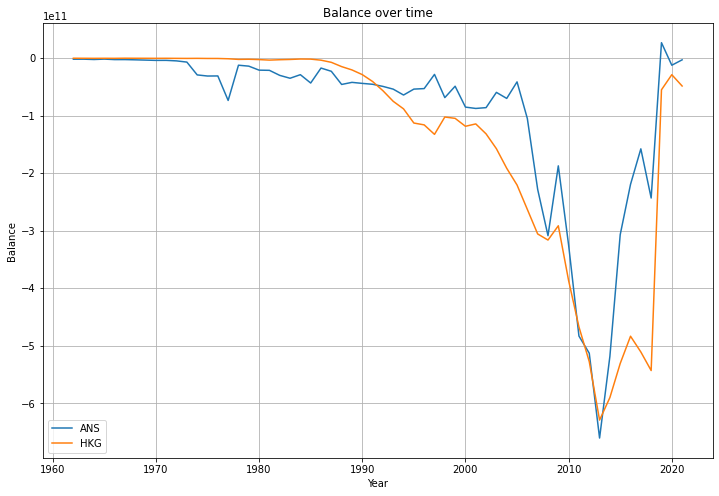

In [75]:
#We'll use the function made brefore to check 
plot_countries(['ANS', 'HKG'])

This cluster represents country with international trade deficits over years, especially during the first half of the last decade. <br>
Since then, they tend to reach balance 

In [76]:
df_trend_pivot.loc[df_trend_pivot['Cluster'] == 2]

year,location_code,1970.0,1971.0,1972.0,1973.0,1974.0,1975.0,1976.0,1977.0,1978.0,...,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,Cluster
44,CHN,-7.609487e+07,1.935830e+08,3.394857e+08,2.684944e+08,-6.867980e+08,-1.385209e+08,8.882056e+08,1.064297e+09,-2.931636e+08,...,7.112707e+11,8.445912e+11,1.019218e+12,8.770105e+11,8.247027e+11,8.017004e+11,5.045983e+11,5.496054e+11,6.779393e+11,2
61,DEU,6.895780e+09,6.558970e+09,8.396141e+09,1.698309e+10,2.675978e+10,2.111834e+10,1.741871e+10,2.721914e+10,2.605952e+10,...,3.143996e+11,3.351827e+11,3.339135e+11,3.346688e+11,3.479593e+11,3.480594e+11,2.533695e+11,2.126851e+11,2.109249e+11,2
114,JPN,2.725701e+09,6.699745e+09,7.882794e+09,1.873994e+09,-5.497726e+08,3.924619e+09,8.171229e+09,1.619193e+10,2.640720e+10,...,-1.102219e+10,-1.721957e+10,7.618997e+10,1.358169e+11,1.332266e+11,1.054908e+11,2.844040e+10,4.529807e+10,3.112997e+10,2
188,SAU,1.393688e+09,2.694187e+09,3.855386e+09,6.528861e+09,2.828514e+10,2.510529e+10,3.149944e+10,2.879912e+10,2.070795e+10,...,2.901030e+11,2.564633e+11,6.619141e+10,7.443490e+10,4.696645e+10,1.029395e+11,1.074661e+11,5.428243e+10,1.337729e+11,2


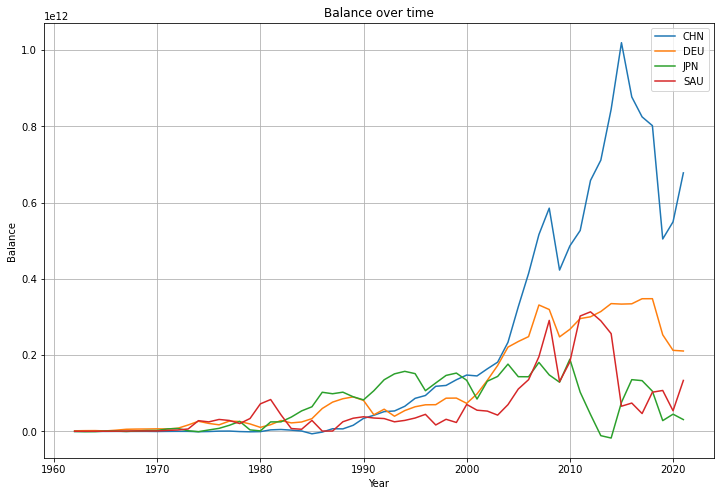

In [77]:
plot_countries(['CHN', 'DEU', 'JPN', 'SAU'])

This cluster is for countries whose balance has increased over years

In [78]:
df_trend_pivot.loc[df_trend_pivot['Cluster'] == 3]

year,location_code,1970.0,1971.0,1972.0,1973.0,1974.0,1975.0,1976.0,1977.0,1978.0,...,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,Cluster
231,USA,3.582411e+09,-1.770633e+09,-5.526521e+09,1.747176e+09,-1.403717e+09,1.311714e+10,-4.525863e+09,-2.903768e+10,-3.910587e+10,...,-5.139913e+11,-5.570006e+11,-5.658194e+11,-5.815871e+11,-6.290806e+11,-7.124123e+11,-9.232164e+11,-9.751280e+11,-1.179840e+12,3


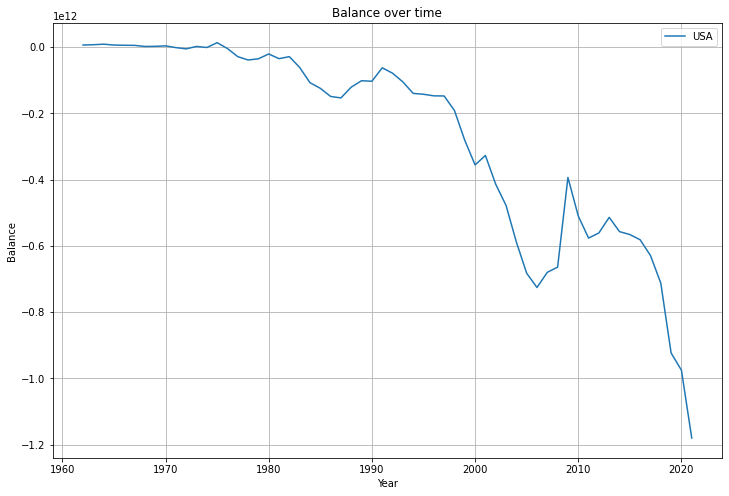

In [79]:
plot_countries(['USA'])

USA seems to be the only one country to know such a decline since 1960. There are surely other countries whose dynamic are similar, but surely not as USA which is like an outlier in our data, and that's why they're alone in their cluster <br>

<br>
The last cluster regroups all other countries that did not respect the pattern of other clusters. Even though their dynamic are surely different, they're surely not as impactful as others to make them drop from their current cluster 

## 3) Product Category Trends

In [57]:
df_cat_trend = df_full

df_cat_trend = df_cat_trend.groupby(['location_code','country_name','Code_1','year']).sum().reset_index()


df_cat_trend.head()

,location_code,country_name,Code_1,year,location_id,partner_id,product_id,export_value,import_value,sitc_eci,sitc_coi
0,ABW,Aruba,0,1988.0,0,1285,1356,26247.0,1152106.0,18.275767,-5.121820
1,ABW,Aruba,0,1989.0,0,3782,4087,1032736.0,8486965.0,32.971283,-9.613134
2,ABW,Aruba,0,1990.0,0,7273,6711,358998.0,36234847.0,-15.545102,-43.273414
3,ABW,Aruba,0,1991.0,0,7587,6910,511392.0,39475110.0,-34.914983,-47.482987
4,ABW,Aruba,0,1992.0,0,9925,9220,3297273.0,45712247.0,-22.961195,-61.671597


In [59]:
df_cat_trend['Balance'] = df_cat_trend['export_value'] - df_cat_trend['import_value']

#Useful columns are kept
df_cat_trend= df_cat_trend[['location_code', 'country_name', 'Code_1', 'year', 'Balance' ]]

df_cat_trend['Code_1'] = df_cat_trend['Code_1'].astype(int)

df_cat_trend.dtypes

<ipython-input-59-4a90a678b172>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat_trend['Code_1'] = df_cat_trend['Code_1'].astype(int)


location_code     object
country_name      object
Code_1             int32
year             float64
Balance          float64
dtype: object

In [60]:
# 1) Left join with name of products
path = 'D:\\Documents\\Python\\Part I\\Datasets\\SITC_Products_S.xlsx'

sitc_products_S = pd.read_excel(path)

sitc_products_S.dtypes

Code_1           int64
Product_name    object
dtype: object

In [61]:
df_cat_trend = pd.merge(df_cat_trend,sitc_products_S, left_on='Code_1', right_on='Code_1', how='left')
df_cat_trend.head()

,location_code,country_name,Code_1,year,Balance,Product_name
0,ABW,Aruba,0,1988.0,-1125859.0,Food and live animals
1,ABW,Aruba,0,1989.0,-7454229.0,Food and live animals
2,ABW,Aruba,0,1990.0,-35875849.0,Food and live animals
3,ABW,Aruba,0,1991.0,-38963718.0,Food and live animals
4,ABW,Aruba,0,1992.0,-42414974.0,Food and live animals


In [63]:
def plot_stacked_bar(target_country):
    # Filter DataFrame for the target country
    country_df = df_cat_trend[df_cat_trend['country_name'] == target_country]

    # Pivot the DataFrame for easier plotting
    pivot_df = country_df.pivot(index='year', columns='Product_name', values='Balance')

    # Plot stacked bar chart
    pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
    
    # Customize the plot
    plt.title(f'Stacked Bar Chart of Population per Category for {target_country}')
    plt.xlabel('Year')
    plt.ylabel('Balance')
    plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


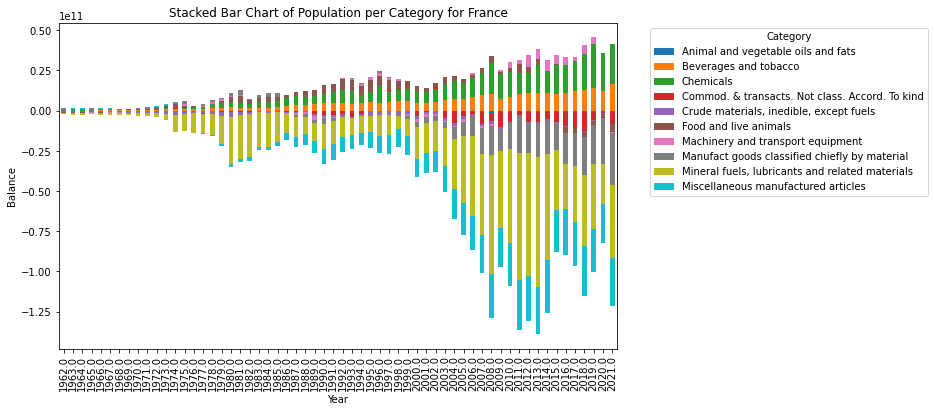

In [64]:
plot_stacked_bar('France')

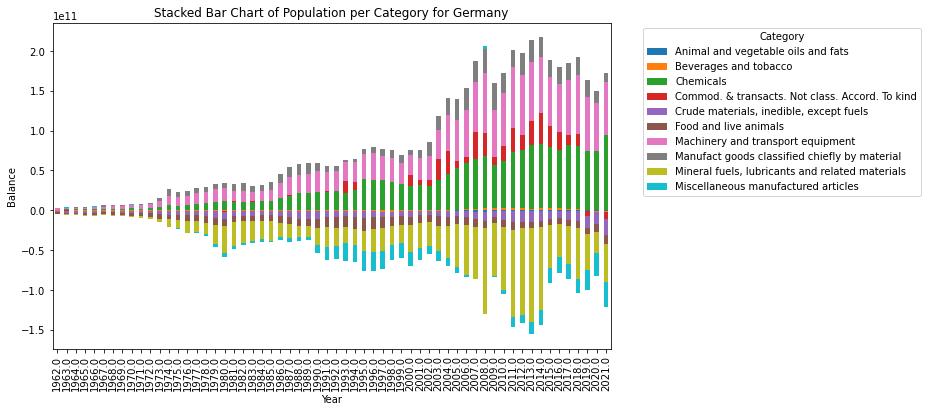

In [101]:
plot_stacked_bar('Germany')

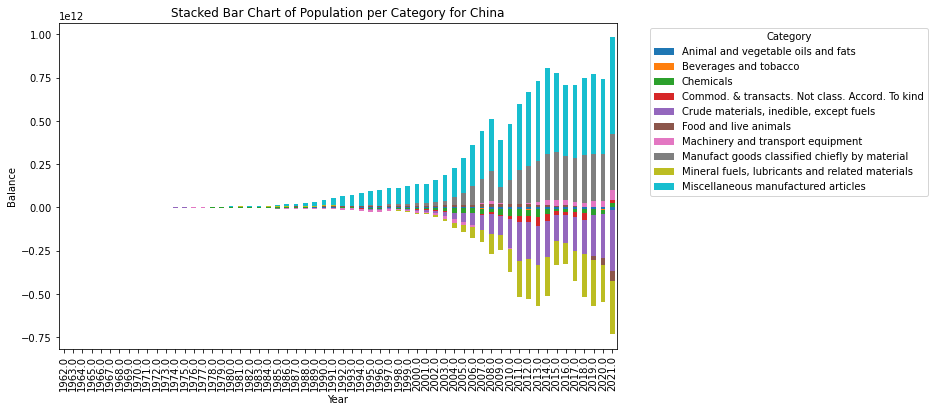

In [99]:
plot_stacked_bar('China')

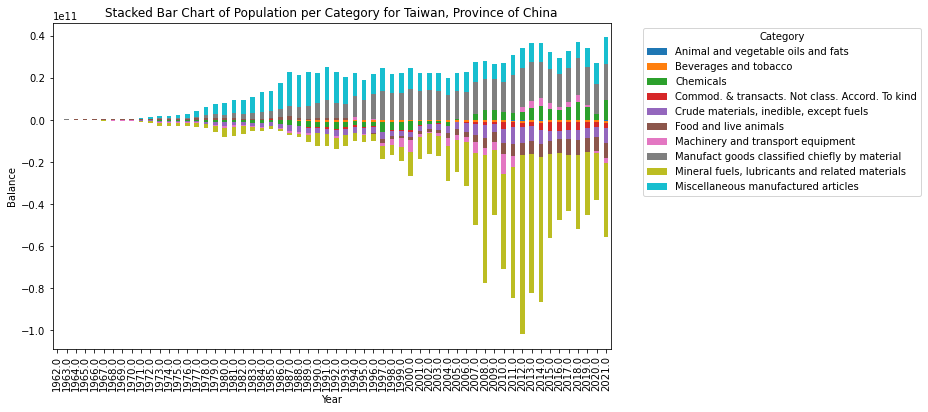

In [104]:
plot_stacked_bar('Taiwan, Province of China')

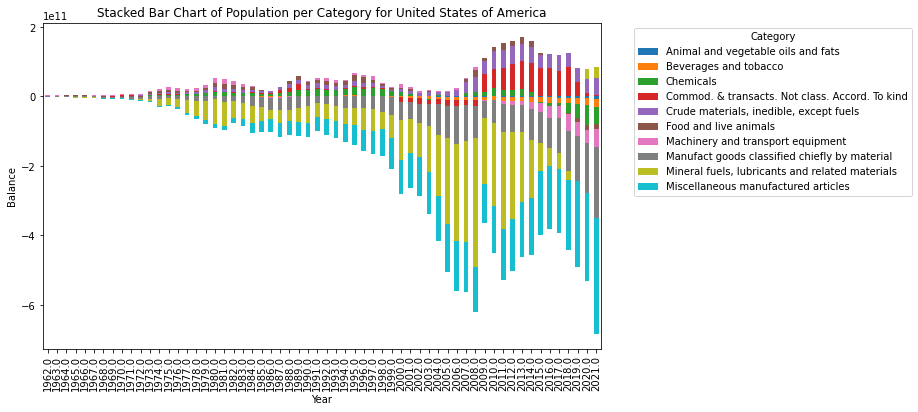

In [106]:
plot_stacked_bar('United States of America')

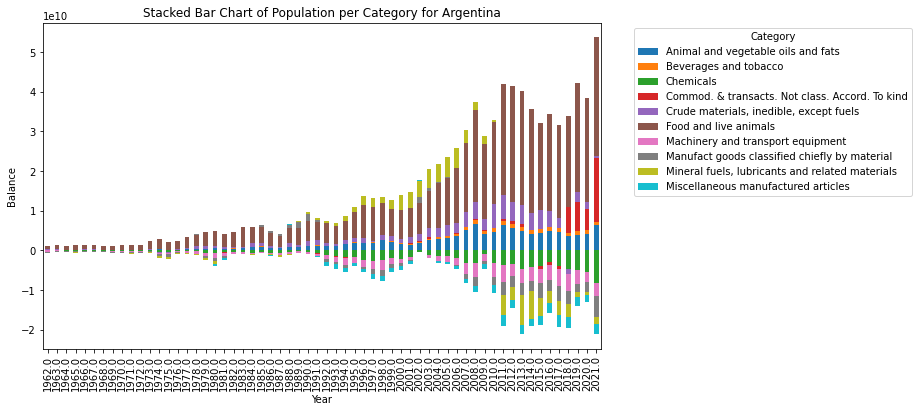

In [102]:
plot_stacked_bar('Argentina')

We can see that European countries (France and Germany) export a lot of chemical products. Germany is a specialist in machinery & transport equipement, while France is an exporter of beverage and tabacco. <br>
Though, they have been lacking of mineral fuels and manufacture almost since 1960, since their balance are negative.
<br>
<br>
On the other hand, China is surely the best importer in terms of manufactured goods (I mean, we can know it without those plots). And even though they have to import a lot of crude materials and mineral fuels, their overall balance is still positive, even nowadays. Taiwan seems to follow the same pattern, but their overall balance is negative <br>
<br>

The USA charts looks like those of European countries, with a lot of imports of fuels and manufactured articles. Still, the import of fuels is the result of a policy to not use them and wait for other countries to run out, before to use it. That's also why fuels that has been imported since 1960, become something they export starting at 2020. This chart empasizes their needs in terms of manufactured goods, and that explain why their overall balance is very negative<br>
<br>
Finally, Argentina offers a completely different chart from other countries. Their overall balance is positive, and food and live animals has been their main strength since 1960. Even in the last decade, they increased their quantities of exported foods/live animals, so it can easily balance their lack in terms of chemical products for example

In [35]:
df_trend_part = df_full

df_trend_part  = df_trend_part.groupby(['location_code','country_name','partner_code', 'partner_name', 'Code_1','year']).sum().reset_index()


df_trend_part.head()

,location_code,country_name,partner_code,partner_name,Code_1,year,location_id,partner_id,product_id,export_value,import_value,sitc_eci,sitc_coi
0,ABW,Aruba,AFG,Afghanistan,0,2018.0,0,4,418,46139.0,0.0,3.200846,0.699855
1,ABW,Aruba,AFG,Afghanistan,0,2019.0,0,4,424,62796.0,0.0,3.742909,-1.128359
2,ABW,Aruba,AFG,Afghanistan,5,2018.0,0,1,136,264681.0,0.0,0.800212,0.174964
3,ABW,Aruba,AFG,Afghanistan,5,2019.0,0,1,136,234024.0,0.0,0.935727,-0.282090
4,ABW,Aruba,AFG,Afghanistan,8,2019.0,0,1,162,2529.0,0.0,0.935727,-0.282090


In [36]:
df_trend_part['Balance'] = df_trend_part['export_value'] - df_trend_part['import_value']

#Useful columns are kept
df_trend_part= df_trend_part[['location_code', 'country_name','partner_code', 'partner_name', 'Code_1', 'year', 'Balance' ]]

df_trend_part['Code_1'] = df_trend_part['Code_1'].astype(int)

df_trend_part.dtypes

location_code     object
country_name      object
partner_code      object
partner_name      object
Code_1             int32
year             float64
Balance          float64
dtype: object

In [39]:
df_trend_part = pd.merge(df_trend_part,sitc_products_S, left_on='Code_1', right_on='Code_1', how='left')
df_trend_part.head()

,location_code,country_name,partner_code,partner_name,Code_1,year,Balance,Product_name
0,ABW,Aruba,AFG,Afghanistan,0,2018.0,46139.0,Food and live animals
1,ABW,Aruba,AFG,Afghanistan,0,2019.0,62796.0,Food and live animals
2,ABW,Aruba,AFG,Afghanistan,5,2018.0,264681.0,Chemicals
3,ABW,Aruba,AFG,Afghanistan,5,2019.0,234024.0,Chemicals
4,ABW,Aruba,AFG,Afghanistan,8,2019.0,2529.0,Miscellaneous manufactured articles


In [40]:

def plot_trade_changes(target_location):
    # Filter DataFrame for the target location
    location_df = df_trend_part[df_trend_part['country_name'] == target_location]

    # Group by partner_name and year, summing up the balance
    grouped_df = location_df.groupby(['partner_name', 'year'])['Balance'].sum().reset_index()

    # Find the top countries with the highest number of trades
    top_countries = grouped_df.groupby('partner_name')['Balance'].sum().nlargest(6).index

    # Filter DataFrame for the top countries
    top_countries_df = grouped_df[grouped_df['partner_name'].isin(top_countries)]

    # Create a facet-style chart
    g = sns.FacetGrid(top_countries_df, col="partner_name", col_wrap=3, height=4, sharey=False)
    g.map(sns.barplot, "year", "Balance", palette="deep",  order=sorted(top_countries_df['year'].unique()))
    
    # The x-axis labels are removed because there are too many years which make the plots illegible
    g.set(xticks=[])

    # Customize the plot
    g.set_axis_labels("year", "Balance")
    g.set_titles(col_template="{col_name}")
    plt.suptitle(f"Trade Changes in {target_location} by Partner Countries", y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


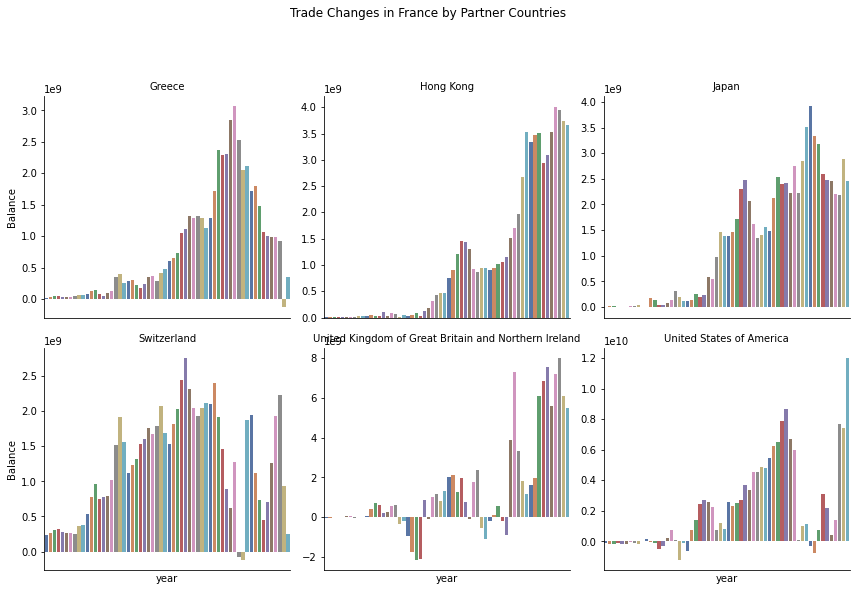

In [41]:
plot_trade_changes('France')

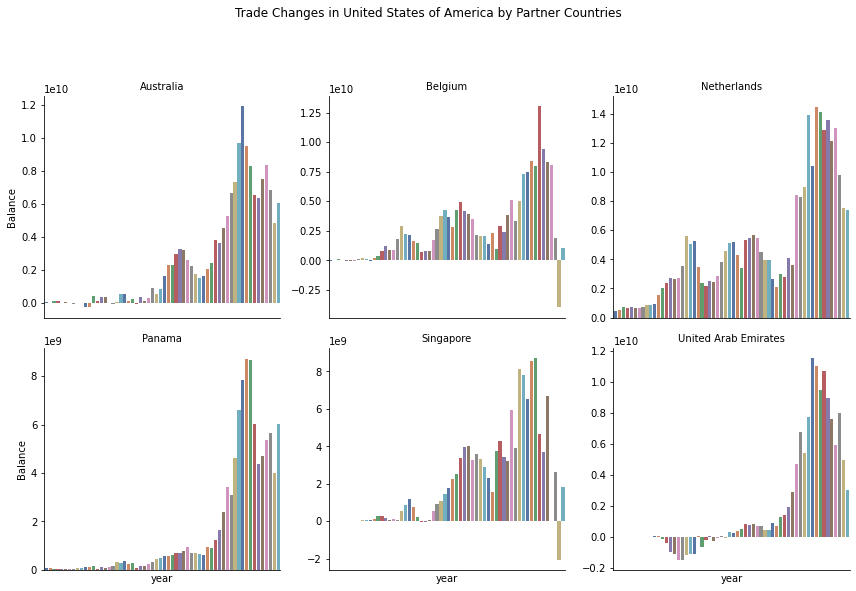

In [42]:
plot_trade_changes('United States of America')

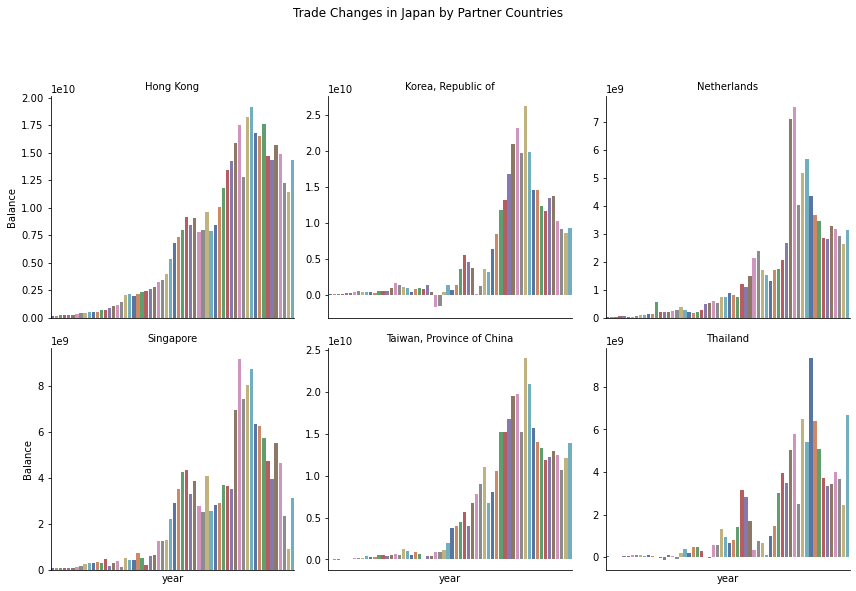

In [43]:
plot_trade_changes('Japan')

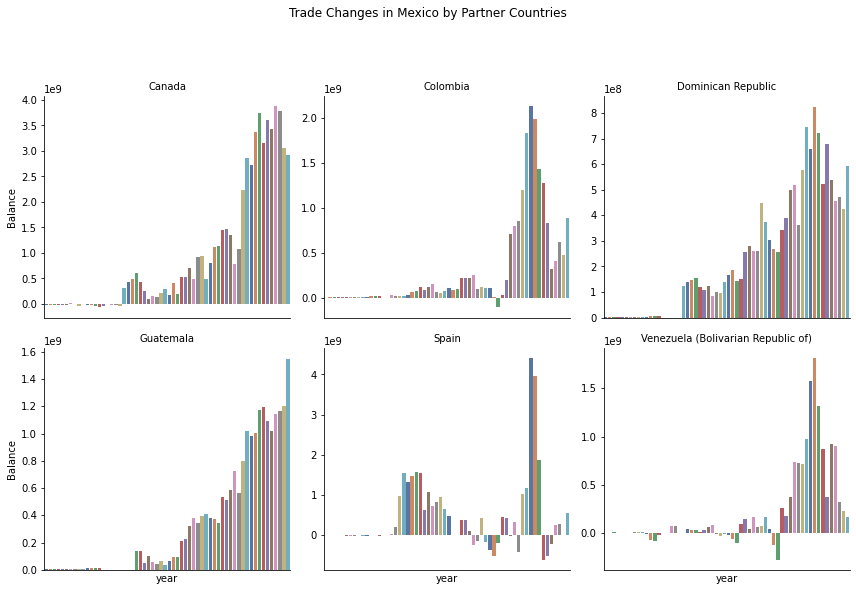

In [44]:
plot_trade_changes('Mexico')

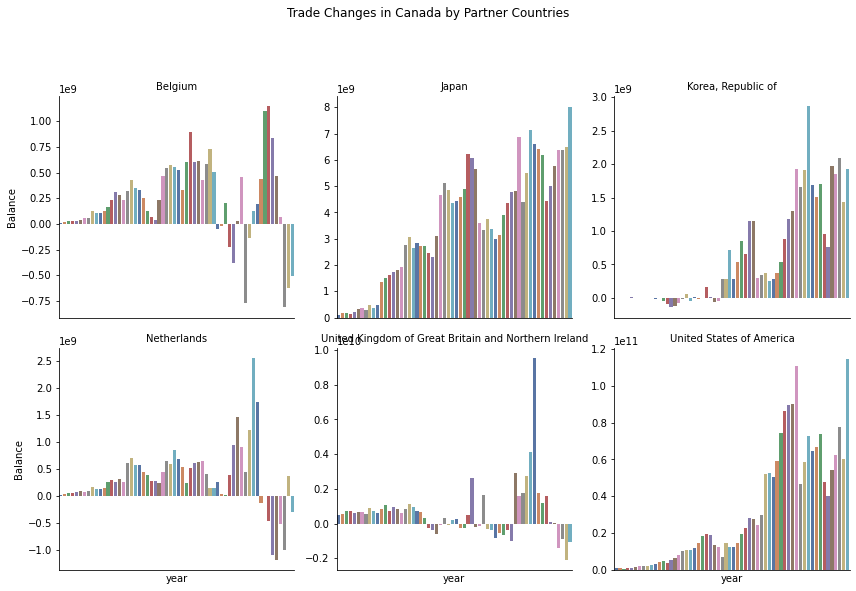

In [45]:
plot_trade_changes('Canada')

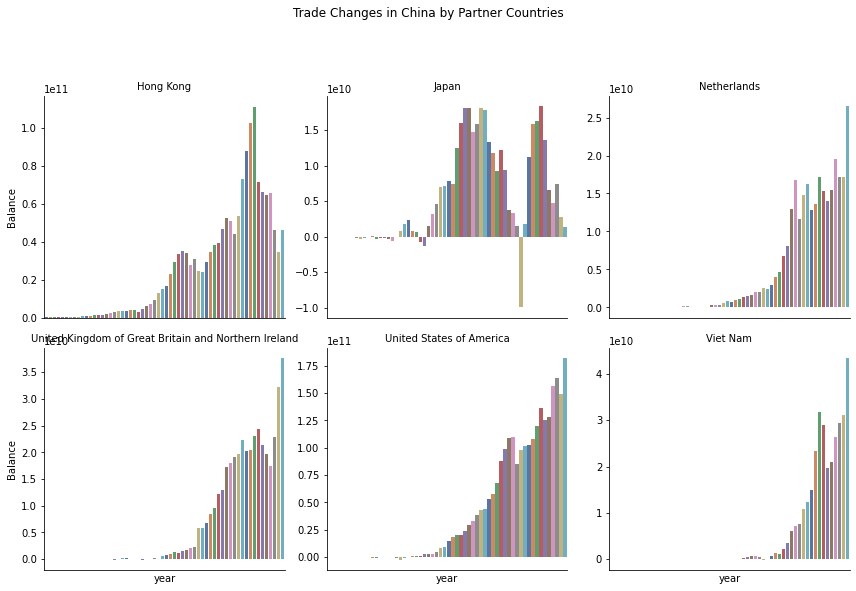

In [46]:
plot_trade_changes('China')

## Predictions

In [244]:
df_p = df_full

df_p = df_p.groupby(['location_code','country_name','Code_1','year']).sum().reset_index()


df_p.head()

,location_code,country_name,Code_1,year,location_id,partner_id,product_id,export_value,import_value,sitc_eci,sitc_coi
0,ABW,Aruba,0,1988.0,0,1285,1356,26247.0,1152106.0,18.275767,-5.121820
1,ABW,Aruba,0,1989.0,0,3782,4087,1032736.0,8486965.0,32.971283,-9.613134
2,ABW,Aruba,0,1990.0,0,7273,6711,358998.0,36234847.0,-15.545102,-43.273414
3,ABW,Aruba,0,1991.0,0,7587,6910,511392.0,39475110.0,-34.914983,-47.482987
4,ABW,Aruba,0,1992.0,0,9925,9220,3297273.0,45712247.0,-22.961195,-61.671597


In [245]:
df_p['Balance'] = df_p['export_value'] - df_p['import_value']
df_p.head()

,location_code,country_name,Code_1,year,location_id,partner_id,product_id,export_value,import_value,sitc_eci,sitc_coi,Balance
0,ABW,Aruba,0,1988.0,0,1285,1356,26247.0,1152106.0,18.275767,-5.121820,-1125859.0
1,ABW,Aruba,0,1989.0,0,3782,4087,1032736.0,8486965.0,32.971283,-9.613134,-7454229.0
2,ABW,Aruba,0,1990.0,0,7273,6711,358998.0,36234847.0,-15.545102,-43.273414,-35875849.0
3,ABW,Aruba,0,1991.0,0,7587,6910,511392.0,39475110.0,-34.914983,-47.482987,-38963718.0
4,ABW,Aruba,0,1992.0,0,9925,9220,3297273.0,45712247.0,-22.961195,-61.671597,-42414974.0


In [246]:
#I know I have some warnings in my function, that's why I import the warning package here
import warnings
warnings.filterwarnings("ignore")

In [247]:
def forecast(country,code): 
    
    #The dataset is filtered according to country and code
    df_t = df_p[(df_p['country_name'] == country) & (df_p['Code_1'] == code )]
    df_t['year'] = df_t['year'].astype(int)
    #we need a datetimeformat for ARIMA
    df_t['year'] = pd.to_datetime(df_t['year'], format='%Y', errors='coerce')
    df_t.set_index('year', inplace=True)
    
    #We make an autoarima and save the parameters so we can use them after
    A_arima = auto_arima(df_t['Balance'])
    order = A_arima.order
    model = sm.tsa.ARIMA(df_t['Balance'], order=order)
    result = model.fit()
    
    forecast_steps = 5
    forecast = result.get_forecast(steps=forecast_steps)
    forecast_values = forecast.predicted_mean
    
    #The dataset is enlarged so it can contains new predicted values
    new_index = pd.date_range(start=df_t.index[-1] + pd.DateOffset(years=1), periods=forecast_steps, freq='A')
    new_data = pd.DataFrame(index=new_index)
    df_t = pd.concat([df_t, new_data])
    df_t['Forecast_Balance'] = None

    for i in range(5):
        df_t.iloc[(df_t.shape[0]-forecast_steps)+i,df_t.shape[1]-1] = forecast_values[i]
    
    #The final result is plotted
    df_t[['Balance', 'Forecast_Balance']].loc['1960-01-01':'2026-01-01'].plot(figsize=(12, 8))
    plt.title(f'Evolution of trade balance for {country} (Category {code})')


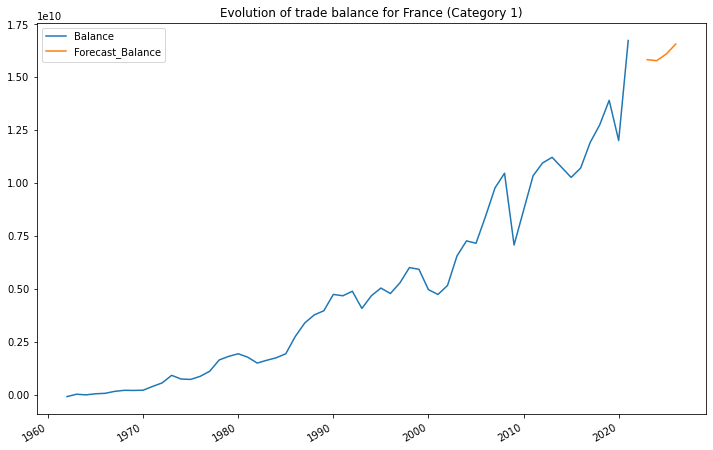

In [248]:
forecast('France','1')

I'm really sorry but I didn't have time to complete this part, so I did what I could to answer the question, but I'm really out of time and I can't work on this since I have 2 other parts to do